# Import library yang dibutuhkan

In [24]:
!pip install tensorflow tensorflow_hub


In [25]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


from sklearn.metrics import classification_report


# Preprocessing Data

## Load & Organisasi Dataset



dataset link drive : https://drive.google.com/file/d/1Geja3K4l4Sdyl0Yb5sBRHEQWzP9d-Yh2/view

In [26]:
!pip install -q gdown

file_id = "1Geja3K4l4Sdyl0Yb5sBRHEQWzP9d-Yh2"
!gdown --id {file_id} -O dataset.zip

import zipfile

with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")  # semua file ke folder 'dataset'

base_dir = "/content/dataset/dataset_skin_capstone"


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Geja3K4l4Sdyl0Yb5sBRHEQWzP9d-Yh2
From (redirected): https://drive.google.com/uc?id=1Geja3K4l4Sdyl0Yb5sBRHEQWzP9d-Yh2&confirm=t&uuid=07d0c6c0-2ebf-45b2-96af-66b8a4acff0a
To: /content/dataset.zip
100% 1.15G/1.15G [00:13<00:00, 86.9MB/s]


 Image Augmentation dan Normalisasi

In [27]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)



Found 1200 images belonging to 3 classes.
Found 299 images belonging to 3 classes.


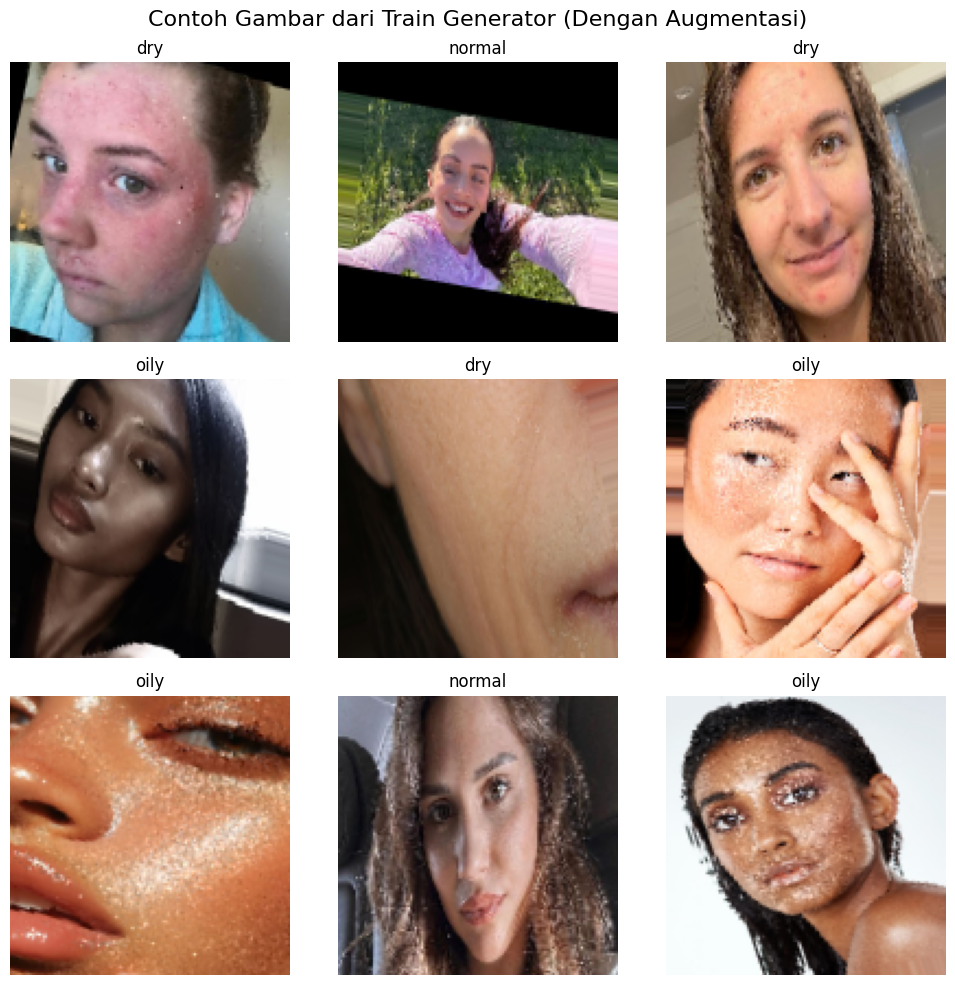

In [28]:
images, labels = next(train_generator)

num_images = 9
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis('off')
plt.suptitle("Contoh Gambar dari Train Generator (Dengan Augmentasi)", fontsize=16)
plt.tight_layout()
plt.show()


# Pembangunan Arsitektur Model cnn dan latih dari Awal

In [29]:
model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # 4 kelas
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Pelatihan Model (Training)

In [30]:
model_cnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model_cnn.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.3423 - loss: 2.0232 - val_accuracy: 0.3344 - val_loss: 1.1188
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.4587 - loss: 1.0304 - val_accuracy: 0.3880 - val_loss: 1.0864
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.4917 - loss: 1.0235 - val_accuracy: 0.4950 - val_loss: 1.0512
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.5359 - loss: 0.9698 - val_accuracy: 0.3679 - val_loss: 1.1501
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.4973 - loss: 0.9979 - val_accuracy: 0.5117 - val_loss: 1.0285
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.5554 - loss: 0.9474 - val_accuracy: 0.4682 - val_loss: 1.0819
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.5443 - loss: 0.9472 - val_accuracy: 0.3813 - val_loss: 1.2445
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.5327 - loss: 0.9440 - val_accuracy: 0.4849 - val_loss:

 # Evaluasi Model

In [31]:
loss, acc = model_cnn.evaluate(val_generator)
print(f"Akurasi validasi: {acc * 100:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - accuracy: 0.1193 - loss: 1.1018
Akurasi validasi: 33.44%


In [34]:
pred_probs = model_cnn.predict(val_generator)

y_pred = np.argmax(pred_probs, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())


print(classification_report(y_true, y_pred, target_names=class_labels))

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step
              precision    recall  f1-score   support

         dry       0.45      0.29      0.35       100
      normal       0.33      0.02      0.04        99
        oily       0.39      0.89      0.54       100

    accuracy                           0.40       299
   macro avg       0.39      0.40      0.31       299
weighted avg       0.39      0.40      0.31       299



# Penyempurnaan Model Transfer learning

In [32]:
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)
)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

model_tf = Model(inputs=base_model.input, outputs=output)

model_tf.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_tf.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)



Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.3315 - loss: 1.1280 - val_accuracy: 0.3110 - val_loss: 1.1076
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.3334 - loss: 1.1209 - val_accuracy: 0.3344 - val_loss: 1.1387
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.3524 - loss: 1.1049 - val_accuracy: 0.3311 - val_loss: 1.1038
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.3574 - loss: 1.1079 - val_accuracy: 0.3344 - val_loss: 1.1267
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.3290 - loss: 1.1229 - val_accuracy: 0.3344 - val_loss: 1.1079


In [35]:
pred_probs = model_tf.predict(val_generator)

y_pred = np.argmax(pred_probs, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())


print(classification_report(y_true, y_pred, target_names=class_labels))

10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 797ms/step
              precision    recall  f1-score   support

         dry       0.00      0.00      0.00       100
      normal       0.00      0.00      0.00        99
        oily       0.33      1.00      0.50       100

    accuracy                           0.33       299
   macro avg       0.11      0.33      0.17       299
weighted avg       0.11      0.33      0.17       299



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Penyempurnaan Model Fine Tuning

In [37]:
model_ft = Model(inputs=base_model.input, outputs=output)
base_model.trainable = True

for layer in base_model.layers[:-20]:
    layer.trainable = False

model_ft.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_ft.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.3215 - loss: 1.1491 - val_accuracy: 0.3344 - val_loss: 1.1099
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.3885 - loss: 1.1005 - val_accuracy: 0.3344 - val_loss: 1.1087
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.3040 - loss: 1.1309 - val_accuracy: 0.3344 - val_loss: 1.1069
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.3246 - loss: 1.1094 - val_accuracy: 0.3344 - val_loss: 1.1049
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.3695 - loss: 1.0964 - val_accuracy: 0.3344 - val_loss: 1.1031
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.3475 - loss: 1.1102 - val_accuracy: 0.3344 - val_loss: 1.1016
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.3103 - loss: 1.1175 - val_accuracy: 0.3344 - val_loss: 1.1004
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.3745 - loss: 1.0975 - val_accuracy: 0.3344 - val_los

10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 890ms/step
              precision    recall  f1-score   support

         dry       0.00      0.00      0.00       100
      normal       0.00      0.00      0.00        99
        oily       0.33      1.00      0.50       100

    accuracy                           0.33       299
   macro avg       0.11      0.33      0.17       299
weighted avg       0.11      0.33      0.17       299



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1000x800 with 0 Axes>

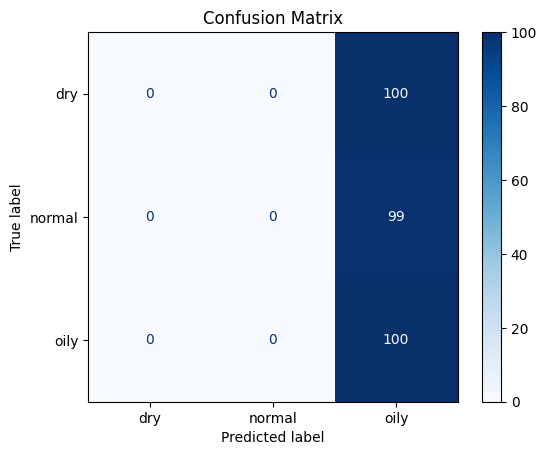

In [40]:


pred_probs = model_ft.predict(val_generator)

y_pred = np.argmax(pred_probs, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()




# Penyempurnaan Model Fine Tuning menggunakan Vit

In [38]:
VIT_URL = "https://tfhub.dev/sayakpaul/vit_b16_fe/1"
IMG_SIZE = 224
vit_feature_extractor = hub.KerasLayer(VIT_URL, trainable=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))


In [39]:
model_vit = Model(inputs=base_model.input, outputs=output)

vit_feature_extractor.trainable = True

model_vit.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)


Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.3418 - loss: 1.1075 - val_accuracy: 0.3344 - val_loss: 1.0979
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.3485 - loss: 1.1079 - val_accuracy: 0.3344 - val_loss: 1.0978
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.3731 - loss: 1.1000 - val_accuracy: 0.3344 - val_loss: 1.0978
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.3454 - loss: 1.1038 - val_accuracy: 0.3712 - val_loss: 1.0979
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.3743 - loss: 1.0993 - val_accuracy: 0.3344 - val_loss: 1.0978


10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 868ms/step
              precision    recall  f1-score   support

         dry       0.00      0.00      0.00       100
      normal       0.00      0.00      0.00        99
        oily       0.33      1.00      0.50       100

    accuracy                           0.33       299
   macro avg       0.11      0.33      0.17       299
weighted avg       0.11      0.33      0.17       299



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1000x800 with 0 Axes>

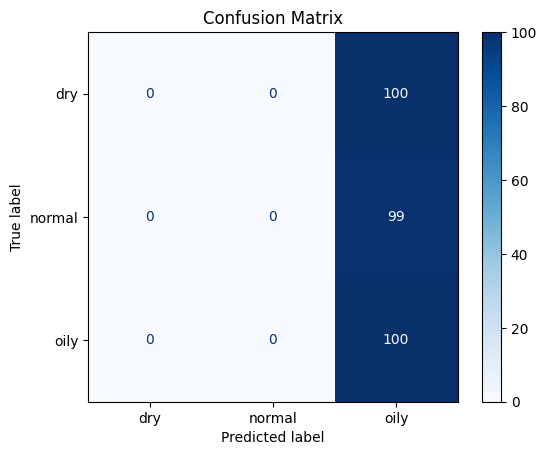

In [41]:
pred_probs = model_vit.predict(val_generator)

y_pred = np.argmax(pred_probs, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())


print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


